# Deep Q-Network (DQN) on LunarLander-v2

> In this post, We will take a hands-on-lab of Simple Deep Q-Network (DQN) on openAI LunarLander-v2 environment. 

## Deep Q-Network (DQN)
---
In this notebook, you will implement a DQN agent with OpenAI Gym's LunarLander-v2 environment.

### Import the Necessary Packages

In [1]:
# !pip install gym[Box_2D] Box2D box2d-py torch

In [2]:
import gym
from gym.wrappers import Monitor
import random
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
import base64, io

import numpy as np
from collections import deque, namedtuple

# For visualization
from gym.wrappers.monitoring import video_recorder
from IPython.display import HTML
from IPython import display 
import glob

### Instantiate the Environment and Agent

Initialize the environment.

In [3]:
env = gym.make('LunarLander-v2')
env.seed(0)
print('State shape: ', env.observation_space.shape)
print('Number of actions: ', env.action_space.n)

State shape:  (8,)
Number of actions:  4


### Define Neural Network Architecture. (3점)

Since `LunarLander-v2` environment is sort of simple envs, we don't need complicated architecture. We just need non-linear function approximator that maps from state to action.

In [4]:
class QNetwork(nn.Module):
    """Actor (Policy) Model."""

    def __init__(self, state_size, action_size, seed):
        """Initialize parameters and build model.
        Params
        ======
            state_size (int): Dimension of each state
            action_size (int): Dimension of each action
            seed (int): Random seed
        """
        super(QNetwork, self).__init__()
        self.seed = torch.manual_seed(seed)
        ############################### TODO: YOUR CODE BELOW ##############################
        ### Q Network에 사용될 layers을 정의해주세요                                          ###
        ####################################################################################
        self.layer1 = nn.Linear(state_size, 128)
        self.layer2 = nn.Linear(128, 64)
        self.layer3 = nn.Linear(64, 32)
        self.layer4 = nn.Linear(32, action_size)
        ################################# END OF YOUR CODE #################################
        
    def forward(self, state):
        """Build a network that maps state -> action values."""
        
        ############################### TODO: YOUR CODE BELOW ##############################
        ###  Forward Pass를 구현해주세요                                                    ###
        ####################################################################################        
        x = F.relu(self.layer1(state))        
        x = F.relu(self.layer2(x))
        x = F.relu(self.layer3(x))
        x = self.layer4(x)
        ################################# END OF YOUR CODE #################################
        
        return x

### Define some hyperparameter (1점)

> 참고로 초매개변수 선택에는 답이 정해져있지 않습니다. 여러 케이스에 대해서 테스트해보고 최적의 조합을 찾아보기 바랍니다.

In [5]:
############################### TODO: YOUR CODE BELOW ##############################
### 초매개변수를 정의해주세요                                                          ###
####################################################################################
BUFFER_SIZE = 100000  # replay buffer size
BATCH_SIZE = 128         # minibatch size
GAMMA = 0.99            # discount factor
TAU = 0.001              # for soft update of target parameters
LR = 0.0001               # learning rate 
UPDATE_EVERY = 10        # how often to update the network
################################# END OF YOUR CODE #################################

In [6]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

### Define Replay Buffer (4점)

In [7]:
class ReplayBuffer:
    """Fixed-size buffer to store experience tuples."""

    def __init__(self, action_size, buffer_size, batch_size, seed):
        """Initialize a ReplayBuffer object.

        Params
        ======
            action_size (int): dimension of each action
            buffer_size (int): maximum size of buffer
            batch_size (int): size of each training batch
            seed (int): random seed
        """
        self.action_size = action_size
        self.memory = deque(maxlen=buffer_size)  
        self.batch_size = batch_size
        self.experience = namedtuple("Experience", field_names=["state", "action", "reward", "next_state", "done"])
        self.seed = random.seed(seed)
    
    def add(self, state, action, reward, next_state, done):
        """Add a new experience to memory."""
        e = self.experience(state, action, reward, next_state, done)
        self.memory.append(e)
    
    def sample(self):
        """Randomly sample a batch of experiences from memory."""
        experiences = random.sample(self.memory, k=self.batch_size)

        ############################### TODO: YOUR CODE BELOW ##############################
        ### Hint1: 실제 torch로 데이터를 처리하기 위해서는 numpy array를 torch tensor로 변환해줘야 합니다. torch.from_numpy()를 참고하기 바랍니다.
        ### Hint2: 경험에서 추출된 정보를 한번에 사용하기 위해서는 주어진 데이터를 쌓아야 합니다. np.vstack()를 참고하기 바랍니다.
        ### Hint3: 각 정보는 형변환이 되어야 합니다. 
        ####################################################################################
        
        # Convert to torch tensors
        states = torch.from_numpy(np.vstack([e.state for e in experiences if e is not None])).float().to(device)
        actions = torch.from_numpy(np.vstack([e.action for e in experiences if e is not None])).long().to(device)
        rewards = torch.from_numpy(np.vstack([e.reward for e in experiences if e is not None])).float().to(device)
        next_states = torch.from_numpy(np.vstack([e.next_state for e in experiences if e is not None])).float().to(device)
        
        # Convert done from boolean to int
        dones = torch.from_numpy(np.vstack([e.done for e in experiences if e is not None]).astype(np.uint8)).float().to(device)        
        
        return (states, actions, rewards, next_states, dones)
        ################################# END OF YOUR CODE #################################

    def __len__(self):
        """Return the current size of internal memory."""
        return len(self.memory)

### Define Agent (6점)

In [8]:
class Agent():
    """Interacts with and learns from the environment."""

    def __init__(self, state_size, action_size, seed):
        """Initialize an Agent object.
        
        Params
        ======
            state_size (int): dimension of each state
            action_size (int): dimension of each action
            seed (int): random seed
        """
        self.state_size = state_size
        self.action_size = action_size
        self.seed = random.seed(seed)

        # Q-Network
        self.qnetwork_local = QNetwork(state_size, action_size, seed).to(device)
        self.qnetwork_target = QNetwork(state_size, action_size, seed).to(device)
        ############################### TODO: YOUR CODE BELOW ##############################
        ### optimizer를 정의해주세요
        ### Hint1: optimizer가 최적화해야 할 weight을 생각해보기 바랍니다.
        ####################################################################################
        self.optimizer = optim.Adam(self.qnetwork_local.parameters(), lr=LR)
        ################################# END OF YOUR CODE #################################

        # Replay memory
        self.memory = ReplayBuffer(action_size, BUFFER_SIZE, BATCH_SIZE, seed)
        # Initialize time step (for updating every UPDATE_EVERY steps)
        self.t_step = 0
    
    def step(self, state, action, reward, next_state, done):
        # Save experience in replay memory
        self.memory.add(state, action, reward, next_state, done)
        
        # Learn every UPDATE_EVERY time steps.
        self.t_step = (self.t_step + 1) % UPDATE_EVERY
        if self.t_step == 0:
            # If enough samples are available in memory, get random subset and learn
            if len(self.memory) > BATCH_SIZE:
                experiences = self.memory.sample()
                self.learn(experiences, GAMMA)

    def act(self, state, eps=0.):
        """Returns actions for given state as per current policy.
        
        Params
        ======
            state (array_like): current state
            eps (float): epsilon, for epsilon-greedy action selection
        """
        state = torch.from_numpy(state).float().unsqueeze(0).to(device)
        
        
        self.qnetwork_local.eval()
        with torch.no_grad():
            ############################### TODO: YOUR CODE BELOW ##############################
            ## TODO: Action을 q network로부터 뽑아내세요.
            ### Hint: 우리가 행동을 뽑아내는 신경망은 어떤 것인지 생각해보기 바랍니다.
            ####################################################################################
            action_values = self.qnetwork_local(state)
            ################################# END OF YOUR CODE #################################
            
        self.qnetwork_local.train()

        ############################### TODO: YOUR CODE BELOW ##############################
        ## 입실론-그리디 탐색을 구현하세요.
        ####################################################################################
        if random.random() > eps:
            ## TODO: 임의의 확률이 eps보다 클때 action 선택 방법
            return np.argmax(action_values.cpu().data.numpy())
        else:
            ## TODO: 임의의 확률이 eps보다 작을때 action 선택 방법
            return random.choice(np.arange(self.action_size))
        ################################# END OF YOUR CODE #################################

    def learn(self, experiences, gamma):
        """Update value parameters using given batch of experience tuples.

        Params
        ======
            experiences (Tuple[torch.Variable]): tuple of (s, a, r, s', done) tuples 
            gamma (float): discount factor
        """
        # Obtain random minibatch of tuples from D
        states, actions, rewards, next_states, dones = experiences

        ## Compute and minimize the loss
        ### Extract next maximum estimated value from target network
        q_targets_next = self.qnetwork_target(next_states).detach().max(1)[0].unsqueeze(1)
        
        ############################### TODO: YOUR CODE BELOW ##############################
        ## bellman equation을 구현해주세요
        ####################################################################################        
        q_targets = rewards + gamma * q_targets_next * (1 - dones)
        ################################# END OF YOUR CODE #################################
        
        ### Calculate expected value from local network
        q_expected = self.qnetwork_local(states).gather(1, actions)
        
        ############################### TODO: YOUR CODE BELOW ##############################
        ## mse를 사용해서 loss를 계산하기 바랍니다.
        ####################################################################################
        loss = F.mse_loss(q_expected, q_targets)
        ################################# END OF YOUR CODE #################################
        
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

        # ------------------- update target network ------------------- #
        self.soft_update(self.qnetwork_local, self.qnetwork_target, TAU)                     

    def soft_update(self, local_model, target_model, tau):
        """Soft update model parameters.
        θ_target = τ*θ_local + (1 - τ)*θ_target

        Params
        ======
            local_model (PyTorch model): weights will be copied from
            target_model (PyTorch model): weights will be copied to
            tau (float): interpolation parameter 
        """
        for target_param, local_param in zip(target_model.parameters(), local_model.parameters()):
            target_param.data.copy_(tau*local_param.data + (1.0-tau)*target_param.data)

### Training Process (5점)

In [9]:
def dqn(n_episodes=2000, max_t=1000, eps_start=1.0, eps_end=0.01, eps_decay=0.995):
    """Deep Q-Learning.
    
    Params
    ======
        n_episodes (int): maximum number of training episodes
        max_t (int): maximum number of timesteps per episode
        eps_start (float): starting value of epsilon, for epsilon-greedy action selection
        eps_end (float): minimum value of epsilon
        eps_decay (float): multiplicative factor (per episode) for decreasing epsilon
    """
    scores = []                        # list containing scores from each episode
    scores_window = deque(maxlen=100)  # last 100 scores
    eps = eps_start                    # initialize epsilon
    for i_episode in range(1, n_episodes+1):
        state = env.reset()
        score = 0
        for t in range(max_t):
            ############################### TODO: YOUR CODE BELOW ##############################
            ## STEP1: action을 agent로부터 뽑습니다.
            action = agent.act(state, eps)
            
            ## STEP2: env.step()을 사용해서 원하는 정보를 뽑습니다.
            next_state, reward, done, _ = env.step(action)
            
            ## STEP3: 뽑아낸 정보를 바탕으로 agent를 학습시킵니다.
            agent.step(state, action, reward, next_state, done)
            
            ## STEP4: 다음 상태로 갱신시킵니다
            state = next_state
            
            ## STEP5: score를 정의해주세요.
            score += reward
            
            ################################# END OF YOUR CODE #################################
            if done:
                break 
        scores_window.append(score)       # save most recent score
        scores.append(score)              # save most recent score
        eps = max(eps_end, eps_decay*eps) # decrease epsilon
        print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)), end="")
        if i_episode % 100 == 0:
            print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)))
        if np.mean(scores_window)>=200.0:
            print('\nEnvironment solved in {:d} episodes!\tAverage Score: {:.2f}'.format(i_episode-100, np.mean(scores_window)))
            torch.save(agent.qnetwork_local.state_dict(), 'checkpoint.pth')
            break
    return scores

agent = Agent(state_size=8, action_size=4, seed=0)
scores = dqn()

Episode 100	Average Score: -257.03
Episode 200	Average Score: -256.11
Episode 300	Average Score: -253.67
Episode 400	Average Score: -176.81
Episode 500	Average Score: -123.97
Episode 600	Average Score: -55.390
Episode 700	Average Score: -67.95
Episode 800	Average Score: -65.90
Episode 900	Average Score: -44.82
Episode 1000	Average Score: -44.98
Episode 1100	Average Score: -35.93
Episode 1200	Average Score: -33.00
Episode 1300	Average Score: -13.28
Episode 1400	Average Score: 67.169
Episode 1500	Average Score: 179.58
Episode 1600	Average Score: 190.05
Episode 1700	Average Score: 197.37
Episode 1710	Average Score: 200.91
Environment solved in 1610 episodes!	Average Score: 200.91


### Plot the learning progress (1점)

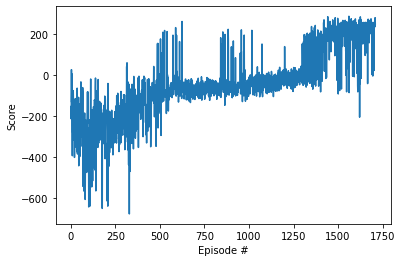

In [10]:
# plot the scores
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(len(scores)), scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

### Animate it with Video

In [11]:
def show_video(env_name):
    mp4list = glob.glob('video/*.mp4')
    if len(mp4list) > 0:
        mp4 = mp4list[0]
        video = io.open(mp4, 'r+b').read()
        encoded = base64.b64encode(video)
        display.display(HTML(data='''<video alt="test" autoplay 
                loop controls style="height: 400px;">
                <source src="data:video/mp4;base64,{0}" type="video/mp4" />
             </video>'''.format(encoded.decode('ascii'))))
    else:
        print("Could not find video")

def wrap_env(env):
    env = Monitor(env, './video', force=True)
    return env

def gen_wrapped_env(env_name):
    return wrap_env(gym.make(env_name))
        
def show_video_of_model(agent, env_name):
    env = gen_wrapped_env(env_name)
    agent.qnetwork_local.load_state_dict(torch.load('checkpoint.pth'))
    state = env.reset()
    done = False
    while not done:
        frame = env.render(mode='rgb_array')
        
        action = agent.act(state)

        state, reward, done, _ = env.step(action)        
    env.close()

In [12]:
agent = Agent(state_size=8, action_size=4, seed=0)
show_video_of_model(agent, 'LunarLander-v2')

In [13]:
show_video('LunarLander-v2')